
## HySWAN Vortex Model: Storm generated waves at each hemisphere.

This is a very simplified example of HySWAN toolbox. 

A storm simulated with Vortex model will be solved using non-stationary SWAN numerical model, a simulation will be done at north hemisphere and a second one at south hemisphere. Outputs are shown to check Vortex behaviour

SWAN scenarios are demo cases based on Majuro and Samoa.

<strong>Workflow</strong>:

- synthethic storm tracks will be generated for both SWAN sites
- SWAN will be feed with a synthethic storm track, and Vortex winds model will generate storm wind fields
- output will be compared between both sites, Majuro for north hemisphere and Samoa for south hemisphere.


In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

# dev library
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..'))

# swan wrap module
from hywaves.swan.wrap import SwanProject, SwanMesh, SwanWrap_NONSTAT

# storms module
from hywaves.swan.storms import track_site_parameters

# plotting
from hywaves.swan.plots.nonstationary import plot_storm_track



## Database

In [2]:
# --------------------------------------
# data
p_data = op.abspath(op.join(os.path.abspath(''), '..', '..', 'data'))
p_demo = op.join(p_data, 'demo', 'nb_demo_majuro_samoa')

# Majuro and Samoa bathymetry
p_bathy_majuro = op.join(p_demo, 'depth_majuro.nc')
p_bathy_samoa = op.join(p_demo, 'depth_samoa.nc')

# Majuro and Samoa coastlines
p_shore_majuro = op.join(p_demo, 'shore_majuro.npy')
p_shore_samoa = op.join(p_demo, 'shore_samoa.npy')


## MAJURO - Load bathymetry and shoreline

In [3]:
# load depth file
xds_bathy = xr.open_dataset(p_bathy_majuro)

# sign convention [0º,360º]
xds_lon = xds_bathy.lon.values
xds_lon[xds_lon<0] = xds_lon[xds_lon<0] + 360
xds_bathy.lon.values[:] = xds_lon

lon = xds_bathy.lon.values[:]
lat = xds_bathy.lat.values[:]

depth = xds_bathy.elevation.values[:] * -1  # elevation to depth 


# shoreline (from .nc file)
np_shore = np.load(p_shore_majuro)

# sign convention [0º,360º]
lon_shore = np_shore[:,0]
lon_shore[lon_shore<0] = lon_shore[lon_shore<0] + 360
np_shore[:,0] = lon_shore



## MAJURO - Generate input storm track (North Hemisphere Vortex) 

In [4]:
# target location
target = 'Majuro'
x0, y0 = 171.18, 7.11       # coordinates
if x0 < 0:  x0 = x0 + 360   # sign convention [0º,360º]

    
# input: waves_event (empty) + storm_track (from MDA parameters)
date_ini = '2000-01-02 00:00'
time = pd.date_range(date_ini, periods=6, freq='H')
we = pd.DataFrame(index=time, columns=['hs', 'per', 'dir', 'spr', 'U10', 'V10'])
we['level'] = 0
we['tide'] = 0


# input: storm_track (from parameters)
pmin = 924.9709      # center pressure 
vmean = 69.0352      # translation velocity (km/h)
delta = 87.8432      # azimut
gamma = 92.7126      # translation angle (nautical convention)
R = 4                # radius in degrees
tstep = 30           # computational time step (minutes) for track interpolation

# storm track from parameters
st = track_site_parameters(
    tstep, pmin, vmean, delta, gamma,
    x0, y0, lon[0], lon[-1], lat[0], lat[-1],
    R, date_ini
)

print('input storm track')
print(st)


input storm track
                        move       vf        vfx       vfy    pn        p0  \
2000-01-02 00:00:00  92.7126  69.0352 -68.957845  3.267168  1013  924.9709   
2000-01-02 00:30:00  92.7126  69.0352 -68.957845  3.267168  1013  924.9709   
2000-01-02 01:00:00  92.7126  69.0352 -68.957845  3.267168  1013  924.9709   
2000-01-02 01:30:00  92.7126  69.0352 -68.957845  3.267168  1013  924.9709   
2000-01-02 02:00:00  92.7126  69.0352 -68.957845  3.267168  1013  924.9709   
2000-01-02 02:30:00  92.7126  69.0352 -68.957845  3.267168  1013  924.9709   
2000-01-02 03:00:00  92.7126  69.0352 -68.957845  3.267168  1013  924.9709   
2000-01-02 03:30:00  92.7126  69.0352 -68.957845  3.267168  1013  924.9709   
2000-01-02 04:00:00  92.7126  69.0352 -68.957845  3.267168  1013  924.9709   
2000-01-02 04:30:00  92.7126  69.0352 -68.957845  3.267168  1013  924.9709   
2000-01-02 05:00:00  92.7126  69.0352 -68.957845  3.267168  1013  924.9709   
2000-01-02 05:30:00  92.7126  69.0352 -68.9578

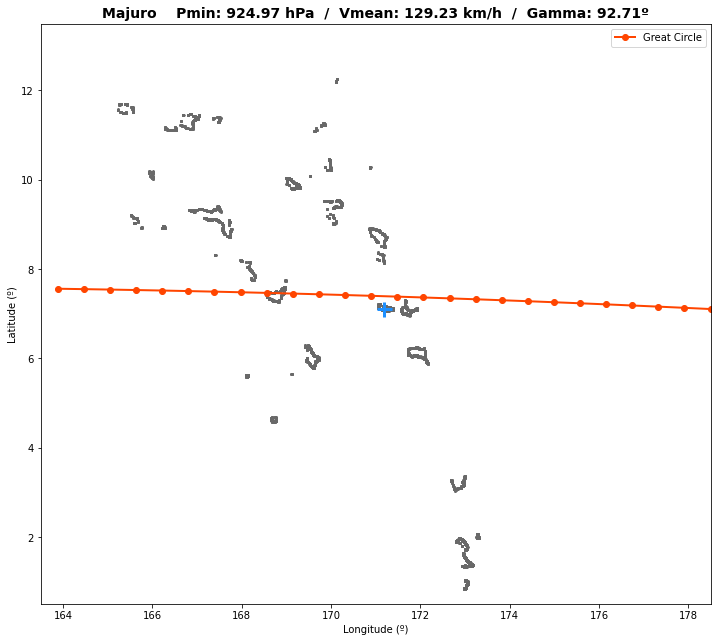

In [5]:
# plot storm track
plot_storm_track(
    'Majuro', st, 0, 
    lon[0], lon[-1], lat[0], lat[-1],
    None, None, None, None, np_shore = np_shore,
)

## MAJURO: Swan Project, meshes and input parameters

In [6]:
# --------------------------------------
# SWAN project 

p_proj = op.join(p_data, 'projects')  # swan projects main directory
n_proj = 'nb_02_majuro'               # project name

sp = SwanProject(p_proj, n_proj)


# --------------------------------------
# SWAN main mesh
main_mesh = SwanMesh()

# depth grid description (input bathymetry grid)
main_mesh.dg = {
    'xpc': lon[0],                             # x origin
    'ypc': lat[0],                             # y origin
    'alpc': 0,                                 # x-axis direction 
    'xlenc': lon[-1]-lon[0],                   # grid length in x
    'ylenc': lat[-1]-lat[0],                   # grid length in y
    'mxc': depth.shape[1]-1,                   # number mesh x
    'myc': depth.shape[0]-1,                   # number mesh y
    'dxinp': (lon[-1]-lon[0])/depth.shape[1],  # size mesh x
    'dyinp': (lat[-1]-lat[0])/depth.shape[0],  # size mesh y
}

# depth value (from file)
main_mesh.depth = depth

# computational grid description
main_mesh.cg = {
    'xpc': 163.5,
    'ypc': 0.5,
    'alpc': 0,
    'xlenc': 15,
    'ylenc': 13,
    'mxc': int(round(15/0.136)),    # grid resolution of 15km (=0.136º)
    'myc': int(round(13/0.136)),
    'dxinp': 15/int(round(15/0.136)),
    'dyinp': 13/int(round(13/0.136)),
}

sp.set_main_mesh(main_mesh)


# --------------------------------------
# SWAN nested meshes


# NEST 1
mesh_nest1 = SwanMesh()

# depth grid description (input bathymetry grid)
# grid resolution of 5km (=0.0453º)
res1 = 0.04533
mesh_nest1.dg = main_mesh.dg

# depth value (from file)
mesh_nest1.depth = main_mesh.depth

# computational grid description
mesh_nest1.cg = {
    'xpc': 168.5,
    'ypc': 5.5,
    'alpc': 0,
    'xlenc': 5.5,
    'ylenc': 3.5,
    'mxc': int(round(5.5/res1)),
    'myc': int(round(3.5/res1)),
    'dxinp': 5.5/int(round(5.5/res1)),
    'dyinp': 3.5/int(round(3.5/res1)),
}


# NEST 2
mesh_nest2 = SwanMesh()

# depth grid description (input bathymetry grid)
# grid resolution of 1km (=0.009º)
res2 = 0.009
mesh_nest2.dg = main_mesh.dg

# depth value (from file)
mesh_nest2.depth = main_mesh.depth

# computational grid description
mesh_nest2.cg = {
    'xpc': 170.9,
    'ypc': 6.8,
    'alpc': 0,
    'xlenc': 1.2,
    'ylenc': 0.7,
    'mxc': int(round(1.2/res2)),
    'myc': int(round(0.7/res2)),
    'dxinp': 1.2/int(round(1.2/res2)),
    'dyinp': 0.7/int(round(0.7/res2)),
}


# set project nested mesh list
sp.set_nested_mesh_list([mesh_nest1, mesh_nest2])


# --------------------------------------
# SWAN parameters (sea level, jonswap gamma)
input_params = {
    'set_level': 0,
    'set_convention': 'NAUTICAL',
    'set_cdcap': 2.5*10**-3,

    'boundw_jonswap': 3.3,
    'boundw_period': 'MEAN',

    'boundn_mode': 'CLOSED',

    'wind_deltinp': '30 MIN',
    'level_deltinp': '1 HR',

    'compute_deltc': '30 MIN',
    'output_deltt': '30 MIN',

    'physics':[
        'WIND DRAG WU',
        'GEN3 ST6 5.7E-7 8.0E-6 4.0 4.0 UP HWANG VECTAU TRUE10',
        'QUAD iquad=8',
        'WCAP',
        'TRIADS',
        'DIFFRAC',
    ],

    'numerics':[
        'PROP BSBT',
    ]
}
sp.set_params(input_params)

# SWAN output points
sp.x_out = [172.5, 172.5, 171]
sp.y_out = [8.5, 9.6, 7.4]


## MAJURO: Build and launch SWAN Vortex cases

In [7]:
# SWAN project wrapper
sw = SwanWrap_NONSTAT(sp)

# build non-stationary cases from wave_events list and storm_tracks list
#sw.build_cases([we], storm_track_list=[st], make_waves=False)

# launch cases
#sw.run_cases()


## MAJURO: SWAN output visualization

In [8]:
# extract grid output from non-stationary cases
xds_out_main = sw.extract_output()
print(xds_out_main)

# TODO: AÑADIR PLOTS

<xarray.Dataset>
Dimensions:  (X: 110, Y: 96, case: 1, time: 11)
Coordinates:
  * Y        (Y) float64 0.5 0.6354 0.7708 0.9062 ... 12.96 13.09 13.23 13.36
  * X        (X) float64 163.5 163.6 163.8 163.9 ... 178.0 178.1 178.2 178.4
  * time     (time) datetime64[ns] 2000-01-02 ... 2000-01-02T05:00:00
Dimensions without coordinates: case
Data variables:
    Hsig     (case, time, X, Y) float32 0.0 0.0 0.0 ... 3.3954348e-16 0.15366285
    Tm02     (case, time, X, Y) float32 nan nan nan ... 1.9268471 2.0479126
    Dir      (case, time, X, Y) float32 nan nan nan ... 262.10352 222.23772
    Dspr     (case, time, X, Y) float32 nan nan nan ... 81.028465 26.462383
    TPsmoo   (case, time, X, Y) float32 nan nan nan ... 1.9466542 2.6622026


In [9]:
# extract output for nested mesh
xds_out_n1 = sw.extract_output(mesh=sp.mesh_nested_list[0])
print(xds_out_n1)

# TODO: repetir para nested mesh 1 y 2

<xarray.Dataset>
Dimensions:  (X: 121, Y: 77, case: 1, time: 10)
Coordinates:
  * Y        (Y) float64 5.5 5.545 5.591 5.636 5.682 ... 8.818 8.864 8.909 8.955
  * X        (X) float64 168.5 168.5 168.6 168.6 ... 173.8 173.9 173.9 174.0
  * time     (time) datetime64[ns] 2000-01-02 ... 2000-01-02T04:30:00
Dimensions without coordinates: case
Data variables:
    Hsig     (case, time, X, Y) float32 0.001903379 0.0019095049 ... 0.0 0.0
    Tm02     (case, time, X, Y) float32 1.4047856 1.4047837 ... nan nan
    Dir      (case, time, X, Y) float32 279.40253 279.1425 278.88562 ... nan nan
    Dspr     (case, time, X, Y) float32 31.507042 31.528782 ... nan nan
    TPsmoo   (case, time, X, Y) float32 1.9607003 1.9607 1.9607003 ... nan nan


## SAMOA - Load bathymetry and shoreline

In [10]:
# load depth file
xds_bathy = xr.open_dataset(p_bathy_samoa)

# sign convention [0º,360º]
xds_lon = xds_bathy.lon.values
xds_lon[xds_lon<0] = xds_lon[xds_lon<0] + 360
xds_bathy.lon.values[:] = xds_lon

lon = xds_bathy.lon.values[:]
lat = xds_bathy.lat.values[:]

depth = xds_bathy.elevation.values[:] * -1  # elevation to depth 


# shoreline (from .nc file)
np_shore = np.load(p_shore_samoa)

# sign convention [0º,360º]
lon_shore = np_shore[:,0]
lon_shore[lon_shore<0] = lon_shore[lon_shore<0] + 360
np_shore[:,0] = lon_shore


## SAMOA - Generate input storm track (South Hemisphere Vortex) 

In [11]:
# target location
target = 'Samoa'
x0, y0 = -172.8, -13.5      # coordinates
if x0 < 0:  x0 = x0 + 360   # sign convention [0º,360º]

    
# input: waves_event (empty) + storm_track (from MDA parameters)
date_ini = '2000-01-02 00:00'
time = pd.date_range(date_ini, periods=6, freq='H')
we = pd.DataFrame(index=time, columns=['hs', 'per', 'dir', 'spr', 'U10', 'V10'])
we['level'] = 0
we['tide'] = 0


# input: storm_track (from parameters)
pmin = 924.9709      # center pressure 
vmean = 69.0352      # translation velocity (km/h)
delta = 87.8432      # azimut
gamma = 92.7126      # translation angle (nautical convention)
R = 4                # radius in degrees
tstep = 30           # computational time step (minutes) for track interpolation

# storm track from parameters
st = track_site_parameters(
    tstep, pmin, vmean, delta, gamma,
    x0, y0, lon[0], lon[-1], lat[0], lat[-1],
    R, date_ini
)

print('input storm track')
print(st)


input storm track
                        move       vf        vfx       vfy    pn        p0  \
2000-01-02 00:00:00  92.7126  69.0352 -68.957845  3.267168  1013  924.9709   
2000-01-02 00:30:00  92.7126  69.0352 -68.957845  3.267168  1013  924.9709   
2000-01-02 01:00:00  92.7126  69.0352 -68.957845  3.267168  1013  924.9709   
2000-01-02 01:30:00  92.7126  69.0352 -68.957845  3.267168  1013  924.9709   
2000-01-02 02:00:00  92.7126  69.0352 -68.957845  3.267168  1013  924.9709   
2000-01-02 02:30:00  92.7126  69.0352 -68.957845  3.267168  1013  924.9709   
2000-01-02 03:00:00  92.7126  69.0352 -68.957845  3.267168  1013  924.9709   
2000-01-02 03:30:00  92.7126  69.0352 -68.957845  3.267168  1013  924.9709   
2000-01-02 04:00:00  92.7126  69.0352 -68.957845  3.267168  1013  924.9709   
2000-01-02 04:30:00  92.7126  69.0352 -68.957845  3.267168  1013  924.9709   
2000-01-02 05:00:00  92.7126  69.0352 -68.957845  3.267168  1013  924.9709   
2000-01-02 05:30:00  92.7126  69.0352 -68.9578

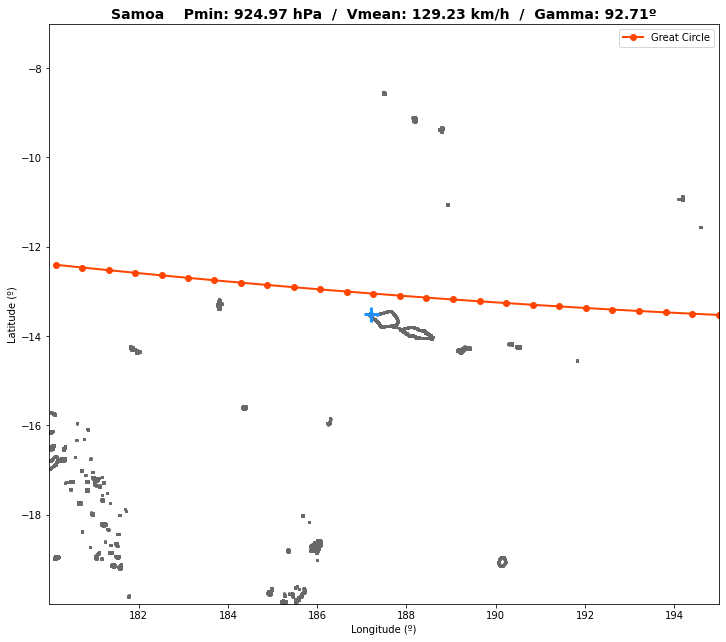

In [12]:
# plot storm track

plot_storm_track(
    'Samoa', st, 0, 
    lon[0], lon[-1], lat[0], lat[-1],
    None, None, None, None, np_shore = np_shore,
)


## SAMOA: Swan Project, meshes and input parameters

In [13]:
# --------------------------------------
# SWAN project (config bathymetry, parameters, computational grid)

p_proj = op.join(p_data, 'projects')  # swan projects main directory
n_proj = 'nb_02_samoa'                # project name

sp = SwanProject(p_proj, n_proj)


# --------------------------------------
# SWAN main mesh
main_mesh = SwanMesh()

# depth grid description (input bathymetry grid)
main_mesh.dg = {
    'xpc': lon[0],                             # x origin
    'ypc': lat[0],                             # y origin
    'alpc': 0,                                 # x-axis direction 
    'xlenc': lon[-1]-lon[0],                   # grid length in x
    'ylenc': lat[-1]-lat[0],                   # grid length in y
    'mxc': depth.shape[1]-1,                   # number mesh x
    'myc': depth.shape[0]-1,                   # number mesh y
    'dxinp': (lon[-1]-lon[0])/depth.shape[1],  # size mesh x
    'dyinp': (lat[-1]-lat[0])/depth.shape[0],  # size mesh y
}

# depth value (from file)
main_mesh.depth = depth

# computational grid description
main_mesh.cg = {
    'xpc': 182,
    'ypc': -20,
    'alpc': 0,
    'xlenc': 12,
    'ylenc': 12.5,
    'mxc': int(round(12/0.136)),    # grid resolution of 15km (=0.136º)
    'myc': int(round(12.5/0.136)),
    'dxinp': 12/int(round(12/0.136)),
    'dyinp': 12.5/int(round(12.5/0.136)),
}

sp.set_main_mesh(main_mesh)

# SWAN parameters (sea level, jonswap gamma, ...)
input_params = {
    'set_level': 0,
    'set_convention': 'NAUTICAL',
    'set_cdcap': 2.5*10**-3,

    'boundw_jonswap': 3.3,
    'boundw_period': 'MEAN',

    'boundn_mode': 'CLOSED',

    'wind_deltinp': '30 MIN',
    'level_deltinp': '1 HR',

    'compute_deltc': '30 MIN',
    'output_deltt': '30 MIN',

    'physics':[
        'WIND DRAG WU',
        'GEN3 ST6 5.7E-7 8.0E-6 4.0 4.0 UP HWANG VECTAU TRUE10',
        'QUAD iquad=8',
        'WCAP',
        'TRIADS',
        'DIFFRAC',
    ],

    'numerics':[
        'PROP BSBT',
    ]
}
sp.set_params(input_params)

# SWAN output points
sp.x_out = [167.5, 167.5, 167]
sp.y_out = [9.5, 9.6, 9.45]


## SAMOA: Build and launch SWAN Vortex cases

In [14]:
# SWAN project wrapper
sw = SwanWrap_NONSTAT(sp)

# build non-stationary cases from wave_events list and storm_tracks list
#sw.build_cases([we], storm_track_list=[st], make_waves=False)

# launch cases
#sw.run_cases()

## SAMOA: SWAN output visualization

In [15]:
# extract grid output from non-stationary cases
xds_out_main = sw.extract_output()
print(xds_out_main)

# TODO: AÑADIR PLOTS


<xarray.Dataset>
Dimensions:  (X: 88, Y: 92, case: 1, time: 11)
Coordinates:
  * Y        (Y) float64 -20.0 -19.86 -19.73 -19.59 ... -7.908 -7.772 -7.636
  * X        (X) float64 182.0 182.1 182.3 182.4 ... 193.5 193.6 193.7 193.9
  * time     (time) datetime64[ns] 2000-01-02 ... 2000-01-02T05:00:00
Dimensions without coordinates: case
Data variables:
    Hsig     (case, time, X, Y) float32 0.0 0.0 ... 4.966171e-22 9.957141e-21
    Tm02     (case, time, X, Y) float32 nan nan nan ... nan 2.480179 0.6853023
    Dir      (case, time, X, Y) float32 nan nan nan nan ... nan 270.0 219.71606
    Dspr     (case, time, X, Y) float32 nan nan nan ... nan 81.028465 81.028465
    TPsmoo   (case, time, X, Y) float32 nan nan nan nan ... nan 2.3520904 nan
